In [1]:
! pip install kaggle --upgrade

In [2]:
# Colab library to upload files to notebook
from google.colab import files

# Upload kaggle API key file
uploaded = files.upload()

uploaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhargava39","key":"66bc8f96f9f32e3dc1b9962d882cfc99"}'}

In [3]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle -v

Kaggle API 1.5.12


In [4]:
! kaggle competitions download -c telecom-churn-case-study-hackathon-gc1

 33% 6.00M/18.4M [00:00<00:00, 62.1MB/s]
100% 18.4M/18.4M [00:00<00:00, 112MB/s] 


In [5]:
! unzip telecom-churn-case-study-hackathon-gc1.zip

Archive:  telecom-churn-case-study-hackathon-gc1.zip
  inflating: data_dictionary.csv     
  inflating: sample.csv              
  inflating: test.csv                
  inflating: train.csv               


# Dependencies

In [6]:
# standard/basics
import re
import numpy as np
import pandas as pd

import missingno as msno

# SK learn

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 

from sklearn.metrics import confusion_matrix, precision_score, recall_score

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# other
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
# load the data
train = pd.read_csv('train.csv')
data_dict = pd.read_csv('data_dictionary.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample.csv')

In [8]:
train.shape, test.shape, data_dict.shape, sample.shape

((69999, 172), (30000, 171), (36, 2), (30000, 2))

In [9]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [10]:
train.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)

In [11]:
train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [12]:
train.isna().sum()

id                     0
circle_id              0
loc_og_t2o_mou       702
std_og_t2o_mou       702
loc_ic_t2o_mou       702
                    ... 
aon                    0
aug_vbc_3g             0
jul_vbc_3g             0
jun_vbc_3g             0
churn_probability      0
Length: 172, dtype: int64

In [13]:
ids = ['id','circle_id']

total_amounts = [i for i in list(train.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(train.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(train.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(train.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(train.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(train.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(train.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(train.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, *total_amounts, *total_outgoing_minutes, *offnetwork_minutes, *average_revenue_3g, 
             *average_revenue_2g, *volume_3g, *volume_2g, *age_on_network, 'churn_probability']

train = train[variables].set_index('id')

In [14]:
train.shape

(69999, 24)

In [15]:
train.isna().sum()

circle_id                0
total_rech_amt_6         0
total_rech_amt_7         0
total_rech_amt_8         0
total_og_mou_6           0
total_og_mou_7           0
total_og_mou_8           0
offnet_mou_6          2768
offnet_mou_7          2687
offnet_mou_8          3703
arpu_3g_6            52431
arpu_3g_7            52134
arpu_3g_8            51582
arpu_2g_6            52431
arpu_2g_7            52134
arpu_2g_8            51582
vol_3g_mb_6              0
vol_3g_mb_7              0
vol_3g_mb_8              0
vol_2g_mb_6              0
vol_2g_mb_7              0
vol_2g_mb_8              0
aon                      0
churn_probability        0
dtype: int64

In [16]:
train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        699

In [17]:
train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
circle_id,69999.0,109.000000,0.000000,109.00,109.000,109.000,109.000,109.00
total_rech_amt_6,69999.0,328.139788,404.211068,0.00,110.000,229.000,438.000,35190.00
total_rech_amt_7,69999.0,322.376363,411.070120,0.00,100.000,220.000,430.000,40335.00
total_rech_amt_8,69999.0,323.846355,426.181405,0.00,90.000,225.000,436.000,45320.00
total_og_mou_6,69999.0,306.451436,465.502866,0.00,44.780,145.280,374.305,10674.03
total_og_mou_7,69999.0,310.572674,479.131770,0.00,42.910,141.230,380.045,8285.64
total_og_mou_8,69999.0,304.513065,477.936832,0.00,38.710,138.360,370.895,14043.06
offnet_mou_6,67231.0,198.874771,316.818355,0.00,34.860,96.480,232.990,8362.36
offnet_mou_7,67312.0,197.153383,322.482226,0.00,32.240,91.885,227.630,7043.98
offnet_mou_8,66296.0,196.543577,324.089234,0.00,31.575,91.800,229.345,14007.34


In [18]:
train.circle_id.unique()

array([109])

In [19]:
X = train.drop(['circle_id'], 1).iloc[:,:-1]
y = train.iloc[:,-1]

X.shape, y.shape

((69999, 22), (69999,))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 22), (14000, 22), (55999,), (14000,))

In [21]:
X_test.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
67573,74,0,167,2.98,0.93,76.89,2.65,0.00,49.26,NaN,...,NaN,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.00,445
151,2038,1504,1204,554.91,516.96,493.83,499.44,454.19,383.29,927.37,...,848.68,424.34,424.34,3765.53,2076.1,2204.20,0.49,0.42,1.36,4321
33051,275,145,145,102.76,0.25,0.00,97.49,0.00,0.00,122.07,...,123.39,122.07,122.07,294.07,339.0,443.78,131.55,64.51,14.71,254
22186,455,1472,850,0.00,2442.36,1670.26,0.00,114.54,24.44,388.97,...,389.00,NaN,NaN,3810.38,0.0,0.00,0.00,0.00,0.00,226
27207,220,555,565,964.36,998.33,1003.54,506.54,492.91,347.79,NaN,...,NaN,NaN,NaN,0.00,0.0,0.00,0.00,0.00,0.00,1895


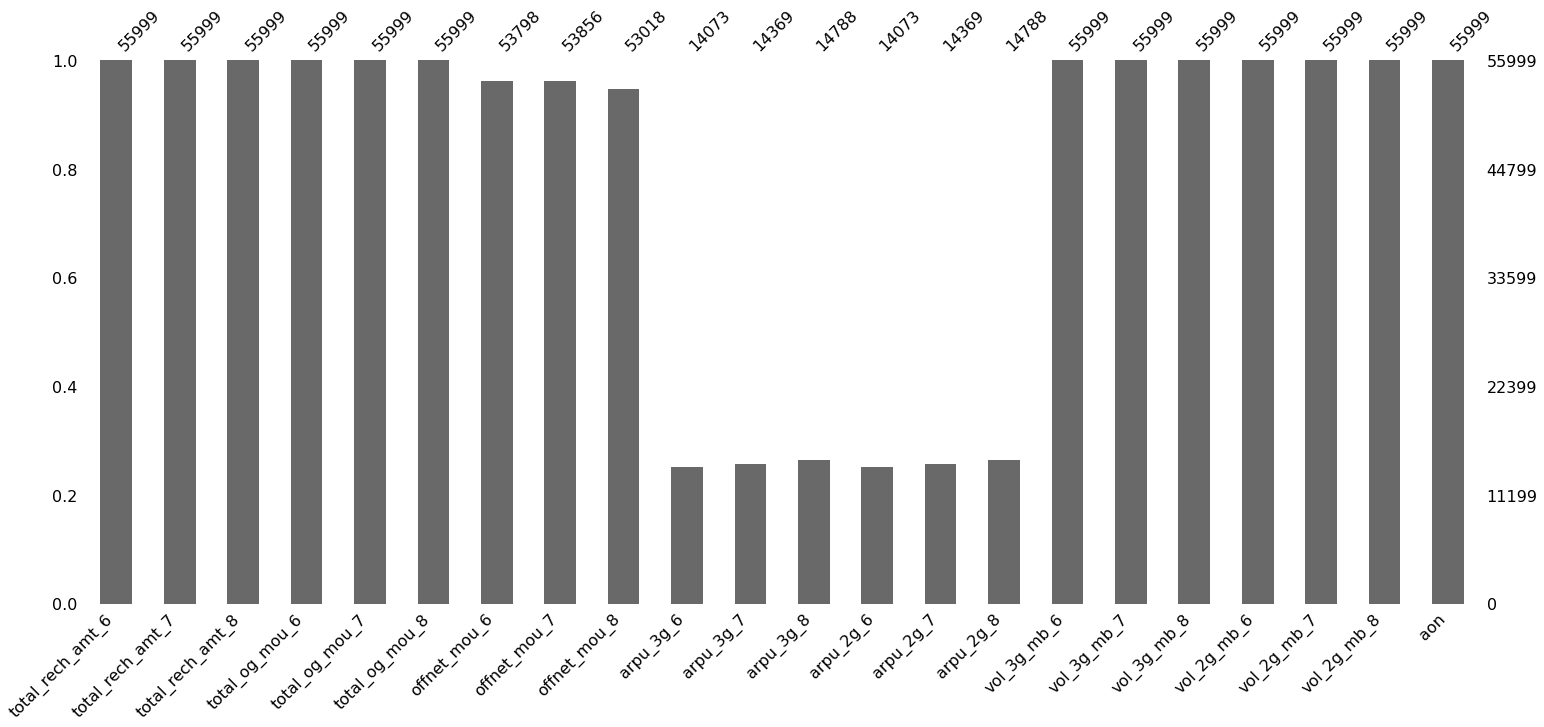

In [22]:
msno.bar(X_train)

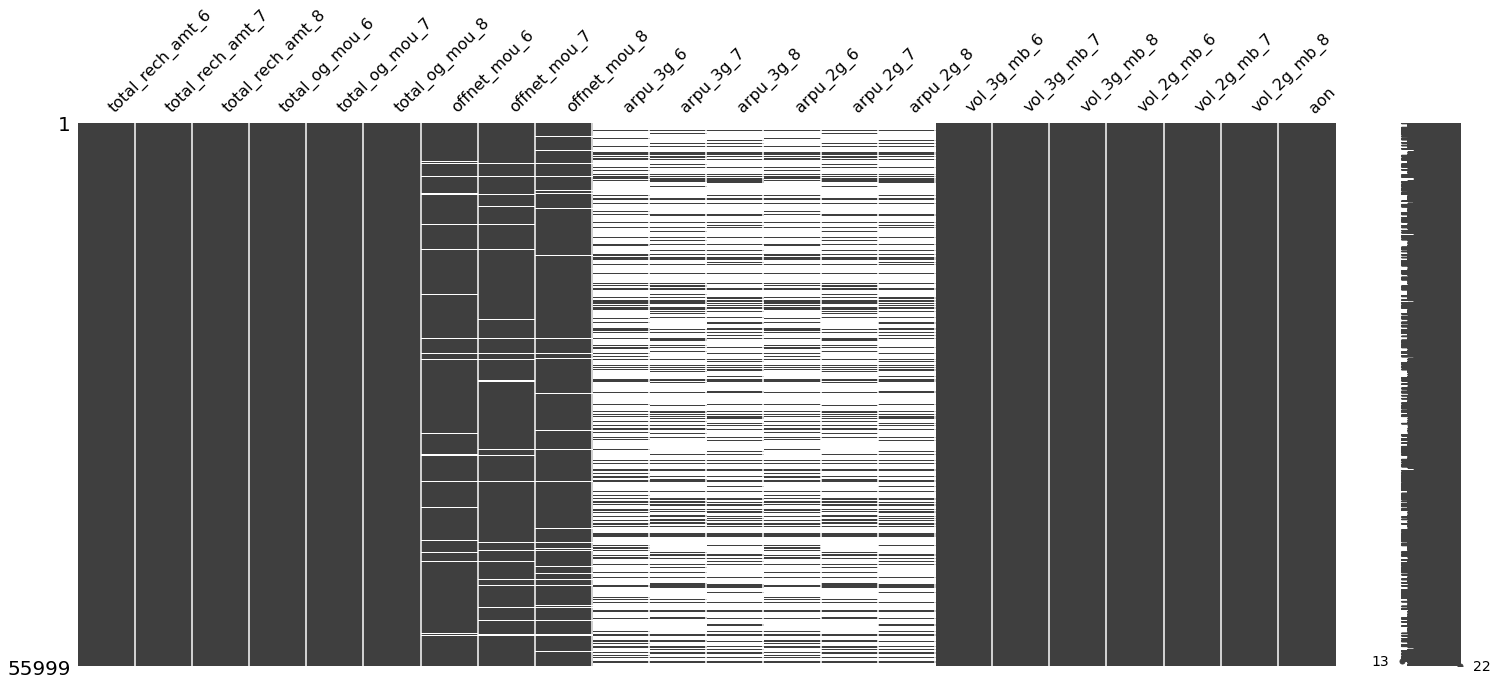

In [23]:
msno.matrix(X_train)

In [24]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
total_og_mou_6       0.000000
total_og_mou_7       0.000000
total_og_mou_8       0.000000
offnet_mou_6         3.930427
offnet_mou_7         3.826854
offnet_mou_8         5.323309
arpu_3g_6           74.869194
arpu_3g_7           74.340613
arpu_3g_8           73.592386
arpu_2g_6           74.869194
arpu_2g_7           74.340613
arpu_2g_8           73.592386
vol_3g_mb_6          0.000000
vol_3g_mb_7          0.000000
vol_3g_mb_8          0.000000
vol_2g_mb_6          0.000000
vol_2g_mb_7          0.000000
vol_2g_mb_8          0.000000
aon                  0.000000
dtype: float64

In [25]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [26]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 16)

In [27]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [28]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

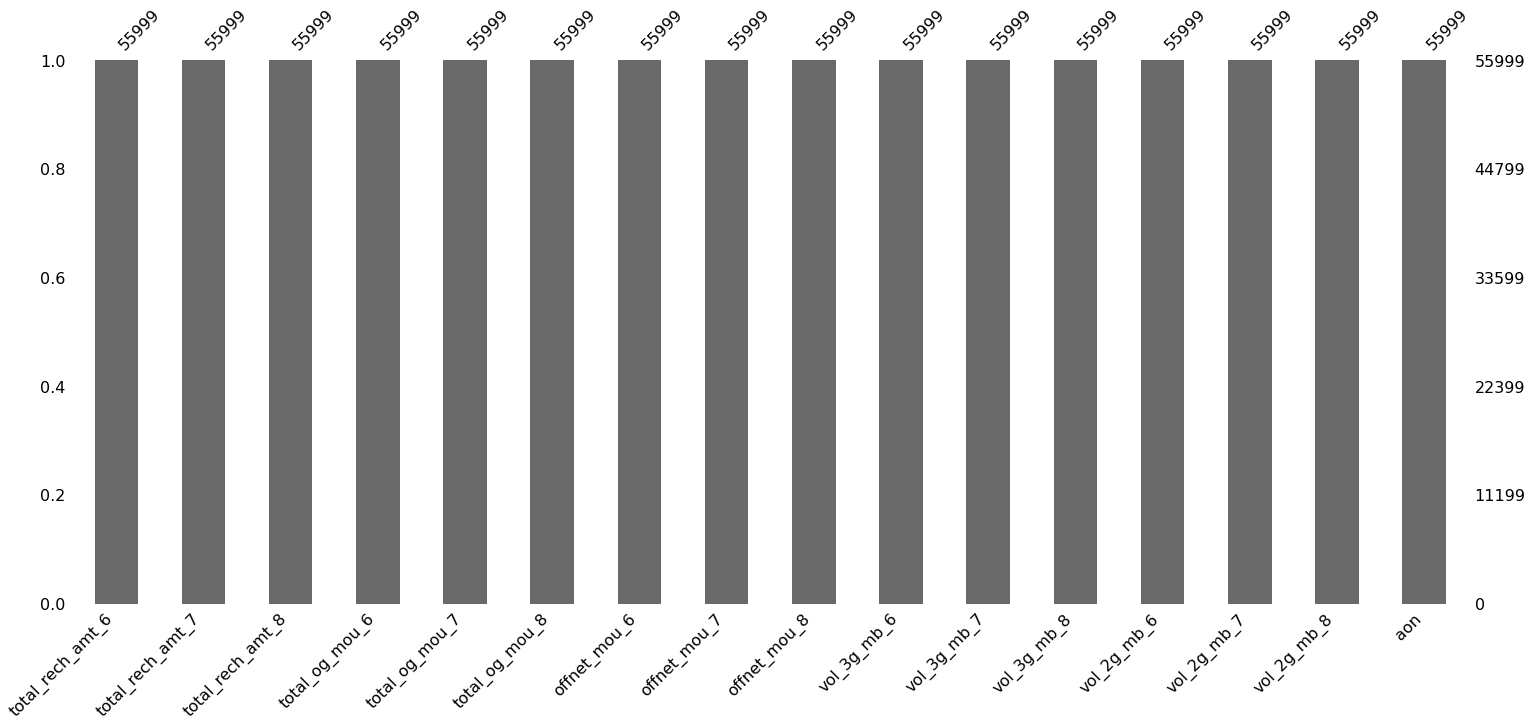

In [29]:
msno.bar(X_train_filtered)

In [30]:
X_train_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
total_rech_amt_6,55999.0,329.112073,413.020401,0.0,110.000,230.00,438.000,35190.00
total_rech_amt_7,55999.0,321.994696,418.172439,0.0,100.000,220.00,430.000,40335.00
total_rech_amt_8,55999.0,323.440294,434.567953,0.0,90.000,224.00,435.000,45320.00
total_og_mou_6,55999.0,307.677894,464.033829,0.0,44.985,146.61,375.240,8488.36
total_og_mou_7,55999.0,310.335668,474.886799,0.0,42.880,141.68,381.255,8285.64
total_og_mou_8,55999.0,304.038174,471.506475,0.0,38.530,138.04,372.185,8309.78
offnet_mou_6,55999.0,191.501099,312.513062,0.0,28.840,90.06,223.720,8362.36
offnet_mou_7,55999.0,189.064877,315.598589,0.0,26.740,85.43,218.110,7043.98
offnet_mou_8,55999.0,185.739673,313.718455,0.0,23.830,83.09,215.910,7857.78
vol_3g_mb_6,55999.0,122.681565,566.330150,0.0,0.000,0.00,0.000,45735.40


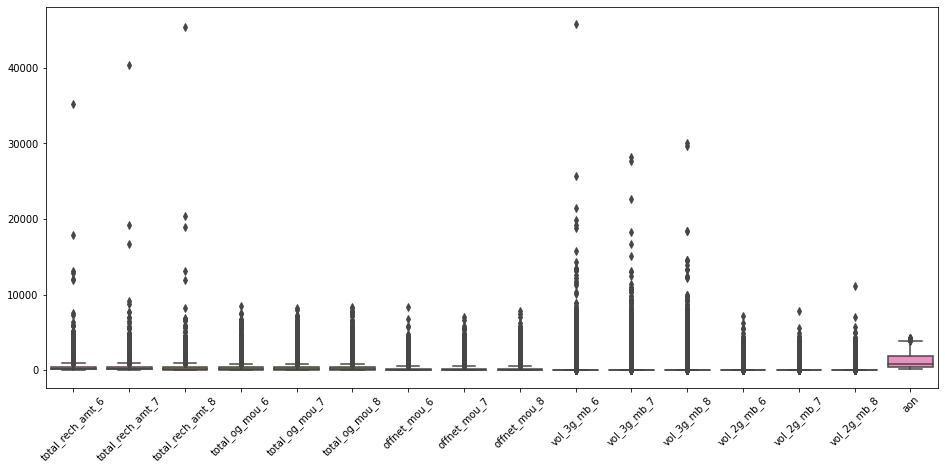

In [31]:
plt.figure(figsize = (16,7))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

In [32]:
def cap_outliers(array, k=3):
  upper_limit = array.mean() + k*array.std()
  lower_limit = array.mean() - k*array.std()
  array[array < lower_limit] = lower_limit
  array[array > upper_limit] = upper_limit
  return array

In [33]:
X_train_filtered_1 = X_train_filtered.apply(cap_outliers, axis=0)

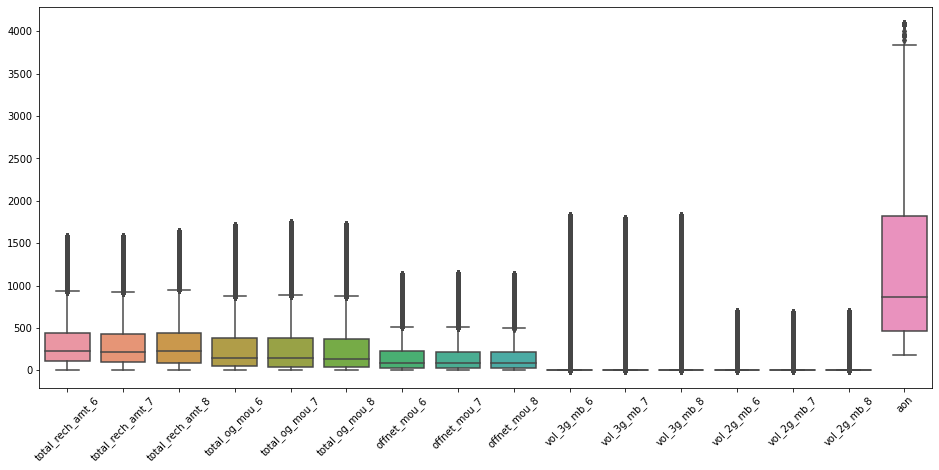

In [34]:
plt.figure(figsize = (16,7))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered_1)

In [35]:
scale = StandardScaler()
X_train_filtered_2 =  scale.fit_transform(X_train_filtered_1)

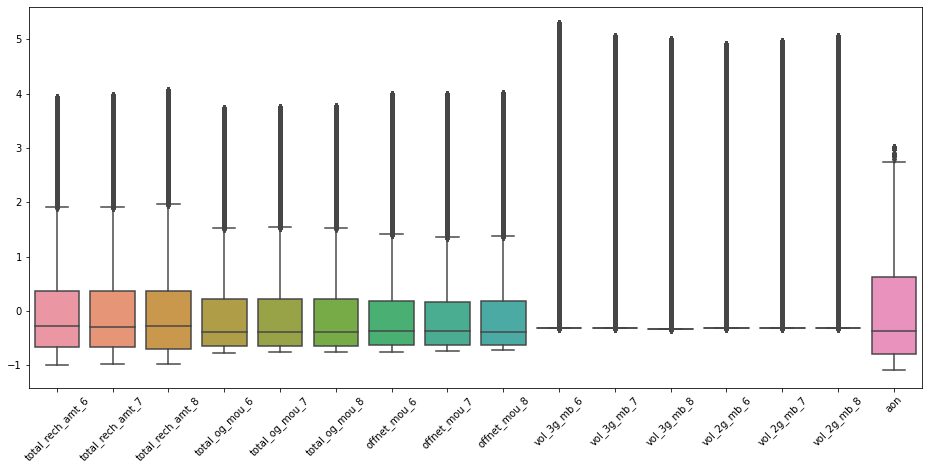

In [36]:
plt.figure(figsize = (16,7))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered_2, columns = new_vars))

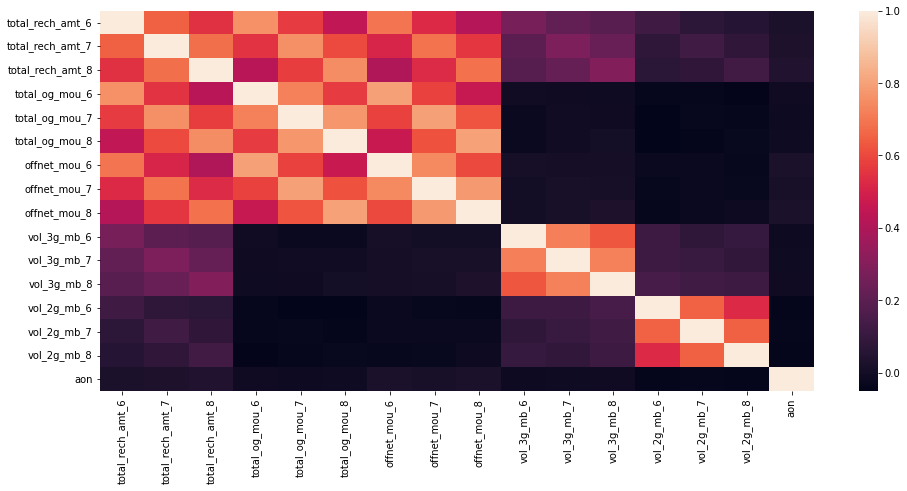

In [37]:
plt.figure(figsize = (16,7))
sns.heatmap(data = pd.DataFrame(X_train_filtered_2, columns = new_vars).corr())

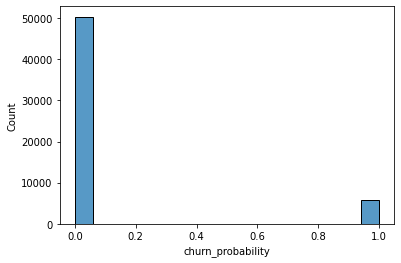

In [38]:
sns.histplot(y_train)

In [39]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered_2, y_train)

RandomForestClassifier(n_jobs=-1)

In [40]:
feature_imp = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})
feature_imp.head()

,col,importance
0,total_rech_amt_6,0.055135
1,total_rech_amt_7,0.053106
2,total_rech_amt_8,0.104217
3,total_og_mou_6,0.059418
4,total_og_mou_7,0.074610


<BarContainer object of 16 artists>

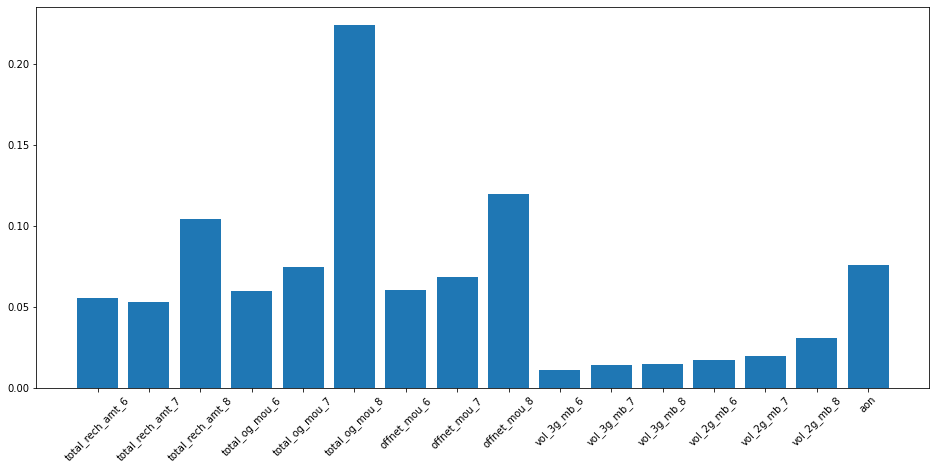

In [41]:
plt.figure(figsize = (16,7))
plt.xticks(rotation=45)
plt.bar(feature_imp['col'], feature_imp['importance'])

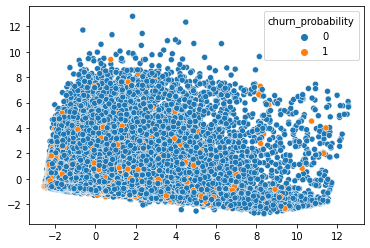

In [42]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered_2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

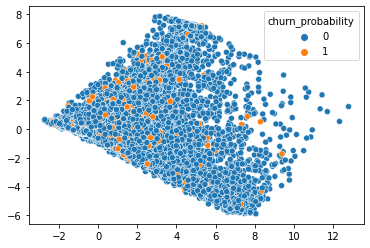

In [43]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

In [45]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col' : ['component_'+ str(i) for i in range(16)], 'importance' : rf.feature_importances_})

<BarContainer object of 16 artists>

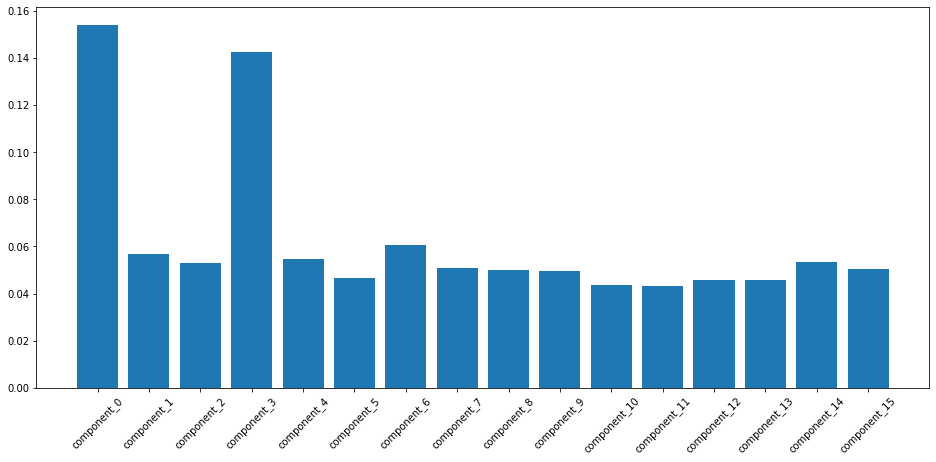

In [46]:
plt.figure(figsize = (16,7))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

In [47]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [48]:
lr.score(pca_components[:,:2], y_train)

0.8981767531563064

In [49]:
im = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter = 10000, tol=0.001)

In [50]:
pipe = Pipeline(steps = [('imputation', imp), ('scaling', scale), ('pca', pca), ('model', lr)])

In [51]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=10000, tol=0.001))])

In [52]:
train_score = pipe.score(X_train[new_vars], y_train)

train_score

0.8994803478633547

In [53]:
test_score = pipe.score(X_test[new_vars], y_test)
test_score

0.9012142857142857

In [54]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12527,    43],
       [ 1340,    90]])

In [55]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.6766917293233082

In [56]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [57]:
unseen = pd.read_csv('test.csv')
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [58]:
unseen.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=171)

In [59]:
type(new_vars)

pandas.core.indexes.base.Index

In [60]:
sub_data = unseen.set_index('id')[new_vars]
sub_data.shape

(30000, 16)

In [61]:
unseen['churn_probability'] = pipe.predict(sub_data)

output = unseen[['id', 'churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [62]:
output.to_csv('Submission.csv', index=False)

In [63]:
! kaggle competitions submit -c telecom-churn-case-study-hackathon-gc1 -f Submission.csv -m "Pipeline"

100% 234k/234k [00:01<00:00, 216kB/s]
Successfully submitted to Telecom Churn Case Study Hackathon